# loading data

loads data in a dictionary with 4 labels and normalise it (or normalise it later)

In [1]:
import os
import scipy.io
import numpy as np

raw_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}
raw_val_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}

training_dir = os.path.join('..', 'data', 'training')
validation_dir = os.path.join('..', 'data', 'validation')

for Dir in [training_dir, validation_dir]:
    for Class in ['normal', 'af', 'other', 'noisy']:
        class_dir = os.path.join(Dir, Class)
        for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
            mat_data = scipy.io.loadmat(file)
            sequence = mat_data['val'][0]
            
            if Dir == training_dir:
                raw_data[Class].append(sequence)
            else:
                raw_val_data[Class].append(sequence)

In [2]:
from scipy.signal import butter,filtfilt
import math

def butter_lowpass_filter(data, cutoff):
    T = 10         # Sample Period
    fs = 150      # sample rate, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2
    n = int(T * fs) # total number of samples

    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def length_transfrom(x, w):
    fs = 300
    tmp = []
    for i in range(w, len(x)):
        curr = 0
        for k in range(i-w+1, i):
            curr += np.sqrt((20/fs)+np.power(x[k]-x[k-1],2))
        tmp.append(curr)
    l = [tmp[0]]*w
    
    return l+tmp

def threshold(x):
    u = np.mean(x)
    peaks = []
    fs = 300
    for i in range(len(x)):
        if (len(peaks) == 0 or i > peaks[-1]+(fs*0.18)) and x[i] > u:
            peaks.append(i)
    return peaks

def _wqrs(x):
    fs = 50
    y = butter_lowpass_filter(x, 15)
    y = length_transfrom(y, math.ceil(fs*.130))
    return threshold(y)

## pre-processing

transform data into 10s segments, remainders are 0 padded. Then downsample to 150Hz (or dont).
Padding using "reflect" adds ~5% accuracy over "mean".

take 770 noisy elements for training and 85 for validation, balance with other classes.

In [4]:
train_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}
val_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}

sampling_freq = 300
down_freq = 300

R = sampling_freq // down_freq

c = 0
s = 0
for idx, data in enumerate([train_data, val_data]):
    for key in data.keys():
        tmp = raw_data if idx == 0 else raw_val_data
        for d in tmp[key]:
            c+=1
            for i in range(0, len(d)+10*(sampling_freq), 10*(sampling_freq)):
                s+=1
                if i+(10*(sampling_freq)) <= len(d):
                    sequence = d[i:i+10*(sampling_freq)]
                    normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
                    data[key].append(normalised_sequence)                
                elif i < len(d):
                    sequence = d[i:]
                    sequence = np.pad(sequence, (0, 10*sampling_freq-len(sequence)), 'reflect')
                    normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
                    data[key].append(normalised_sequence)
                data[key][-1] = data[key][-1].reshape(-1, R).mean(axis=1)
            if s >= 1710:
                print(c)
                

train_data['normal'] = train_data['normal'][:400]
train_data['af'] = train_data['af'][:200]
train_data['other'] = train_data['other'][:170]
train_data['noisy'] = train_data['noisy'][:770]

val_data['normal'] = val_data['normal'][:50]
val_data['af'] = val_data['af'][:20]
val_data['other'] = val_data['other'][:15]
val_data['noisy'] = val_data['noisy'][:85]

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649


KeyboardInterrupt: 

In [5]:
for data in [train_data, val_data]:
    print('-----\n')
    print('normal:', len(data['normal']))
    print('af:', len(data['af']))
    print('other:', len(data['other']))
    print('noisy:', len(data['noisy']), '\n')
    print('total:', len(data['normal']) + len(data['af']) + len(data['other']) + len(data['noisy']))


-----

normal: 400
af: 200
other: 170
noisy: 770 

total: 1540
-----

normal: 50
af: 20
other: 15
noisy: 85 

total: 170


In [6]:
!pip3 install py-ecg-detectors --upgrade

Requirement already up-to-date: py-ecg-detectors in /Users/Yoav2/opt/anaconda3/lib/python3.8/site-packages (1.1.0)


In [14]:
import pandas as pd
from tqdm import tqdm
from ecgdetectors import Detectors
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import skew, kurtosis

def get_SQIs(x, target=0):
    fs = 300
    sSQI = skew(x, bias=False)
    kSQI = kurtosis(x, fisher=False, bias=False)
    
    def get_first_idx(x, a):
        for i in range(len(x)):
            if x[i] >= a:
                    return i

    def get_last_idx(x, a):
        for i in range(len(x)):
            if x[i] >= a:
                return i-1
                
    f, Pxx_den = welch(x, fs=300)
    u1 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 15)], x=f[get_first_idx(f, 5):get_last_idx(f, 15)])
    u2 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 40)], x=f[get_first_idx(f, 5):get_last_idx(f, 40)])
    u3 = simps(Pxx_den[get_first_idx(f, 1):get_last_idx(f, 40)], x=f[get_first_idx(f, 1):get_last_idx(f, 40)])
    u4 = simps(Pxx_den[get_first_idx(f, 0):get_last_idx(f, 40)], x=f[get_first_idx(f, 0):get_last_idx(f, 40)])

    pSQI = (u1/u2)
    basSQI = (u3/u4)
            
    detectors = Detectors(down_freq)
    
    wqrs = _wqrs(x)
    eplimited = detectors.hamilton_detector(x)
    count = 0
    j = 0
    k = 0
    while j < len(wqrs) and k < len(eplimited):
        if wqrs[j] >= eplimited[k]-0.13*fs and wqrs[j] <= eplimited[k]+0.13*fs:
            count += 1
            j+=1
            k+=1
        elif wqrs[j] > eplimited[k]:
            k+=1
        else:
            j+=1

    bSQI = (count/len(wqrs))
    rSQI = (len(wqrs)/(len(wqrs)+len(eplimited)))
    
    return [sSQI, kSQI, pSQI, basSQI, bSQI, rSQI, target]

train_table = pd.DataFrame(columns=['sSQI','kSQI','pSQI','basSQI','bSQI','rSQI', 'target'])
count = 0
for Class in train_data:
    target = 1 if Class == 'noisy' else 0
    for i in tqdm(range(len(train_data[Class]))):
        train_table.loc[count] = get_SQIs(train_data[Class][i], target)
        count += 1
train_table.head()

100%|██████████| 770/770 [01:08<00:00, 11.29it/s]


,sSQI,kSQI,pSQI,basSQI,bSQI,rSQI,target
0,2.302984,12.573987,0.677885,0.915717,0.866667,0.517241,0.0
1,4.144167,22.010114,0.675984,0.947223,1.000000,0.480000,0.0
2,3.933585,19.762409,0.686723,0.943999,0.928571,0.518519,0.0
3,0.596628,10.936016,0.684572,0.680153,0.875000,0.533333,0.0
4,3.880149,20.533434,0.634762,0.977505,1.000000,0.500000,0.0


In [15]:
sSQI_u = train_table['sSQI'].mean() 
kSQI_u = train_table['kSQI'].mean() 

sSQI_var = train_table['sSQI'].var() 
kSQI_var = train_table['kSQI'].var() 

train_table['sSQI'] = train_table['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
train_table['kSQI'] = train_table['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

In [16]:
val_table = pd.DataFrame(columns=['sSQI','kSQI','pSQI','basSQI','bSQI','rSQI', 'target'])
count = 0
for Class in val_data:
    target = 1 if Class == 'noisy' else 0
    for i in tqdm(range(len(val_data[Class]))):
        val_table.loc[count] = get_SQIs(val_data[Class][i], target)
        count += 1

100%|██████████| 85/85 [00:07<00:00, 11.21it/s]


In [17]:
val_table['sSQI'] = val_table['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
val_table['kSQI'] = val_table['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

val_table.head()

print(sSQI_u, kSQI_u)
print(sSQI_var, kSQI_var)

0.6069403650409879 12.020490338630156
4.72925495603184 193.46540694710228


# SVM 


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load

x_train = train_table.drop(['target'], axis='columns')
y_train = train_table.target

x_test = val_table.drop(['target'], axis='columns')
y_test = val_table.target


model = SVC(C=25, gamma=1, probability=True)
model.fit(x_train, y_train)
dump(model, 'model_1_03_21.joblib');

0.8823529411764706


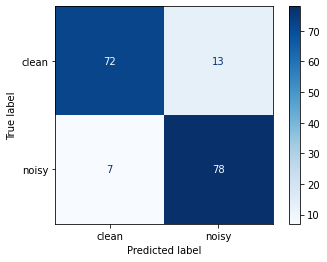

In [19]:
import matplotlib.pyplot as plt
print(model.score(x_test, y_test))
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['clean', 'noisy'])
disp.plot(cmap=plt.cm.Blues)


In [264]:
errors = y_test[model.predict(x_test) != y_test]